In [1]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence


## Import functions for the experiment : 

from experiment_functions import *

### Taming for Langevin Algorithms

We consider the problem of sampling from a probability measure $ \pi $ having a density on $ \mathbb{R}^d $ known up to a normalizing constant, $ x \mapsto e^{-U(x)}/\int_{\mathbb{R}^d} e^{-U(y)} dy $

The Euler discretization of the Langevin stochastic differential equation (SDE) is known to be unstable in a precise sense, when the potential $U$ is superlinear, i.e. $ \liminf_{\|x\| \to +\infty} \frac{\|\nabla U(x)\|}{\|x\|} = +\infty $. 

In that case, the second order moment of the process $lim_{+\infty} \mathbb{E}[X_n^{2}] = +\infty$ and the sample path $(X_n)_n$ diverges to infinity with a positive probability. This is why we introduce new schemes such as Taming to address this problem. 


------------------------------------------------------------------------------------------------------------------------------------------------------
First example, we consider the following target distribution, called the double well : 

$ \pi(x) = \frac{e^{-U(x)}}{\int_{\mathbb{R}^d} e^{-U(y)} \, dy} \space \propto \space  e^{-U(x)} $ 

We know the target distribution up the normalizing constant and the potential function here is : 

$U(x) = \frac{1}{4} \left\| x \right\|^4 - \frac{1}{2} \left\| x \right\|^2  $

So the potential here is superlinear. We are going to verify that the ULA diverges with a positive probability in this case. 


In [31]:
def grad_double_well(x) : 


    alpha = np.linalg.norm(x, axis = 1) ** 2 - 1

    return alpha[:, np.newaxis] * x

In [41]:
def plot_density_DW(plot_sample = None): 

    x_axis = np.linspace(-5, 5, 200)
    y_axis = np.linspace(-5, 5, 200)

    xx_axis, yy_axis = np.meshgrid(x_axis, y_axis)

    pos = np.dstack((xx_axis, yy_axis))
    
    # Compute the pdf 

    norm = np.linalg.norm(pos, axis = 2)

    pdf = np.exp(-((1/4) * (norm ** 4) - (1/2) * (norm ** 2)))
    
    # Plot the result

    plt.figure(figsize=(8, 8))
    plt.contourf(xx_axis, yy_axis, pdf, levels=50, cmap='Blues', alpha=0.4) 
    ## levels : nombre de niveaux de couleurs ; cmap : choix de la palette de couleurs ; alpha : transparence
    plt.colorbar()
    
    if plot_sample is not None:
        x = plot_sample[:, 0]
        y = plot_sample[:, 1]
        plt.scatter(x, y, alpha=0.5, s = 8, color = 'red')

    plt.title('Double Well density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

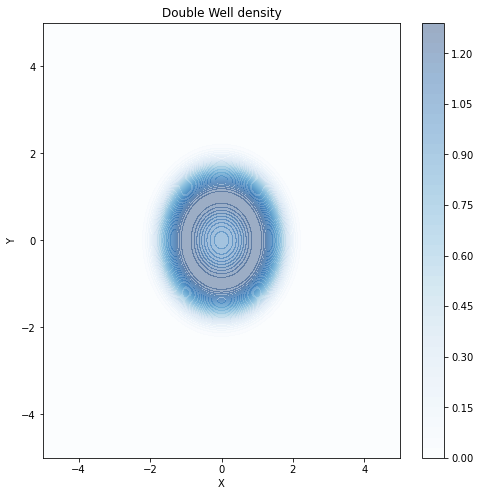

In [42]:
plot_density_DW()

In [51]:
def ULA_double_well(x_init, nb_iter, step) : 

    x = x_init

    dim_sample = x.shape[0]

    dim_var = x.shape[1]

    stochastic_term = np.zeros(x.shape[0])

    gradient_term = np.zeros(x.shape[0])

    for i in tqdm(range(nb_iter)):

        # Each iteration we compute the gradient of the target distribution and update the position of the particles
        grad = grad_double_well(x)

        noise =  np.sqrt(2 * step) * np.random.randn(dim_sample, dim_var)

        stochastic_term += np.linalg.norm(noise, axis = 1)

        gradient_term += np.linalg.norm(step * grad, axis = 1) #Size of this vector is nb_particles

        x = x - step * grad + noise

    plot_density_DW(x)

    return f'The magnitude of the Stochastic term is {np.mean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.mean(gradient_term / nb_iter)}'


    

In [57]:
sample_init = np.random.randn(1000, 2)

100%|██████████| 10000/10000 [00:03<00:00, 3322.69it/s]


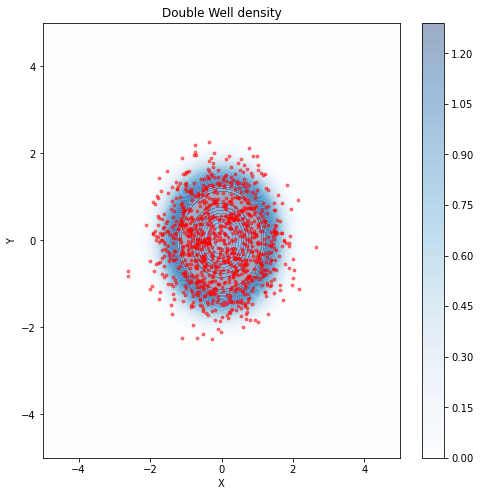

'The magnitude of the Stochastic term is 0.5604737068364573 whereas the magnitude of the gradient term is 0.14245350514926716'

In [65]:
ULA_double_well(sample_init, 10000, 0.1)

We introduce the tamed step size to prevent the process from diverging. In the case of the double-well density, we can tame only the superlinear part of the density : 
$G_\gamma(x) = \frac{\|x\|^2 x - x}{1 + \gamma \|x\|^2}$

In [68]:
def ULA_double_well_tamed(x_init, nb_iter, step) : 

    x = x_init

    dim_sample = x.shape[0]

    dim_var = x.shape[1]

    stochastic_term = np.zeros(x.shape[0])

    gradient_term = np.zeros(x.shape[0])

    for i in tqdm(range(nb_iter)):

        norm_sample = np.linalg.norm(x, axis = 1)

        tamed_step = ((norm_sample ** 2)[:, np.newaxis] * x) / (1 + step * norm_sample)[:, np.newaxis] - x

        # Each iteration we compute the gradient of the target distribution and update the position of the particles
        grad = grad_double_well(x)

        noise =  np.sqrt(2 * tamed_step) * np.random.randn(dim_sample, dim_var)

        stochastic_term += np.linalg.norm(noise, axis = 1)

        gradient_term += np.linalg.norm(tamed_step * grad, axis = 1) #Size of this vector is nb_particles

        x = x - tamed_step * grad + noise

    plot_density_DW(x)

    return f'The magnitude of the Stochastic term is {np.mean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.mean(gradient_term / nb_iter)}'


    

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_48284/4202571112.py:22: RuntimeWarning: invalid value encountered in sqrt
  noise =  np.sqrt(2 * tamed_step) * np.random.randn(dim_sample, dim_var)
100%|██████████| 10/10 [00:00<00:00, 300.77it/s]


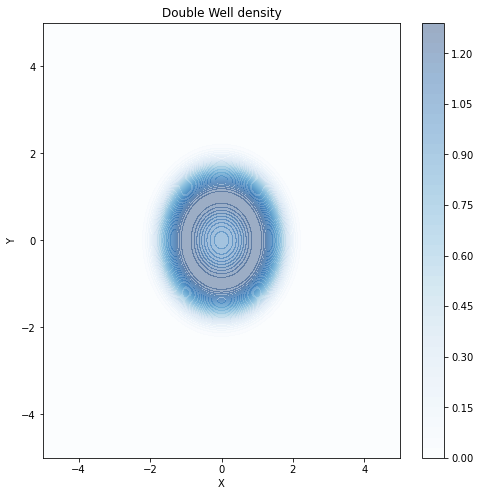

'The magnitude of the Stochastic term is nan whereas the magnitude of the gradient term is nan'

In [70]:
ULA_double_well_tamed(sample_init, 10, 0.001)